# Autoencoder

In [1]:
import sys
sys.path.append("models/")
from setup import out_dir, data_dir, image_dir, model_dir
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import json
from collections import OrderedDict
import logging
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt
import glob
import pandas as pd

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms
import torch.nn.functional as F

try:
    from tensorboardX import SummaryWriter
    is_tensorboard_available = True
except Exception:
    is_tensorboard_available = False

from dataloader import get_loader, image_loader, load_demo
from autoencoder import Autoencoder_raw
from BM1_util_train_test import load_model, train, test

torch.backends.cudnn.benchmark = True

logging.basicConfig(
    format='[%(asctime)s %(name)s %(levelname)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)
logger = logging.getLogger(__name__)

global_step = 0

[2022/01/26 17:27:43 matplotlib.backends DEBUG] - backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
demo_cs, demo_np = load_demo(data_dir)

[2022/01/26 17:27:43 numexpr.utils INFO] - Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2022/01/26 17:27:43 numexpr.utils INFO] - NumExpr defaulting to 8 threads.


In [7]:
zoomlevel = 'zoom13'
output_dim = 1
model_run_date = "22012503"
sampling = 'stratified'

device = torch.device("cuda:2" if torch.cuda.is_available() else "cuda:2")
#device = torch.device("cpu")

In [4]:
args = {'image_size': 224, 
        'depth': -1,
       'base_channels':64,
       'output_dim':output_dim,
       'num_demo_vars':0,
       'cardinality':1,
       'epochs':200,
       'batch_size':16,
       'base_lr':0.001,
       'weight_decay':0.0005,
       'momentum': 0.9,
       'nesterov': True,
       'milestones': '[150,225]',
       'lr_decay':0.1,
       'seed': 1234,
       'outdir':out_dir,
       'num_workers':8,
       'tensorboard':False,
       'save':True}

model_config = OrderedDict([
    ('arch', 'resnext'),
    ('depth', args['depth']),
    ('base_channels', args['base_channels']),
    ('cardinality', args['cardinality']),
    ('output_dim', args['output_dim']),
    ('num_demo_vars', args['num_demo_vars'])
])

optim_config = OrderedDict([
    ('epochs', args['epochs']),
    ('batch_size', args['batch_size']),
    ('base_lr', args['base_lr']),
    ('weight_decay', args['weight_decay']),
    ('momentum', args['momentum']),
    ('nesterov', args['nesterov']),
    ('milestones', json.loads(args['milestones'])),
    ('lr_decay', args['lr_decay']),
])

data_config = OrderedDict([
    ('dataset', 'CIFAR10'),
    ('image_size', args['image_size'])
])

run_config = OrderedDict([
    ('seed', args['seed']),
    ('outdir', args['outdir']),
    ('save', args['save']),
    ('num_workers', args['num_workers']),
    ('tensorboard', args['tensorboard']),
])

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('data_config', data_config),
    ('run_config', run_config),
])

In [5]:
# parse command line arguments
#config = parse_args()
#logger.info(json.dumps(config, indent=2))

model_name = datetime.now().strftime("%m%d-%H%M")

run_config = config['run_config']
optim_config = config['optim_config']

# TensorBoard SummaryWriter
writer = SummaryWriter(model_name) if run_config['tensorboard'] else None

# set random seed
seed = run_config['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# create output directory
outdir = run_config['outdir']
if not os.path.exists(outdir):
    os.makedirs(outdir)

# save config as json file in output directory
outpath = os.path.join(outdir, 'config.json')
with open(outpath, 'w') as fout:
    json.dump(config, fout, indent=2)

In [6]:
# data loaders
train_loader, test_loader = image_loader(image_dir+zoomlevel+"/", data_dir, optim_config['batch_size'], 
                                         run_config['num_workers'], 
                                         data_config['image_size'], sampling=sampling, 
                                         recalculate_normalize=False)

In [8]:
criterion = nn.MSELoss(reduction='mean')
# criterion = my_loss

In [10]:
# model
config['model_config']['input_shape'] = (1,3,data_config['image_size'],data_config['image_size'])

encoder = load_model(config['model_config']['arch'], 'Encoder', config['model_config'])
encoder = encoder.to(device)

config['model_config']['input_shape'] = [1,2048,config['model_config']['output_dim'],config['model_config']['output_dim']]

config['model_config']['conv_shape'] = [data_config['image_size']//32,data_config['image_size']//32]
config['model_config']['output_channels'] = 3

decoder = load_model(config['model_config']['arch'], 'Decoder', config['model_config'])
decoder = decoder.to(device)

config['encoder'] = encoder
config['decoder'] = decoder
model = load_model('autoencoder','Autoencoder_raw', config)
model = model.to(device)

n_params = sum([param.view(-1).size()[0] for param in encoder.parameters()]) +\
           sum([param.view(-1).size()[0] for param in decoder.parameters()])
logger.info('n_params: {}'.format(n_params))

# optimizer
# optimizer = torch.optim.SGD(
#     model.parameters(),
#     lr=optim_config['base_lr'],
#     momentum=optim_config['momentum'],
#     weight_decay=optim_config['weight_decay'],
#     nesterov=optim_config['nesterov'])

# scheduler = torch.optim.lr_scheduler.MultiStepLR(
#     optimizer,
#     milestones=optim_config['milestones'],
#     gamma=optim_config['lr_decay'])

# Test with Adam Optimizer (easier to setup, experiment with SGD later)
optimizer = torch.optim.Adam(model.parameters(), lr=optim_config['base_lr'],
                             weight_decay=optim_config['weight_decay'])


ref1 = 0
ref2 = 0

for epoch in range(optim_config['epochs']):

    loss_ = train(epoch, model, optimizer, criterion, train_loader, run_config,
         writer, device, logger=logger)

#     scheduler.step()

    loss_test_ = test(epoch, model, criterion, test_loader, run_config,
                    writer, device, logger, return_output=False)

    if epoch % 5 == 0:
        if epoch > 50:
            if (np.abs(loss_ - ref1)/ref1<0.005) & (np.abs(loss_ - ref2)/ref2<0.005):
                print("Early stopping at epoch", epoch)
                break
            if (ref1 < loss_) & (ref1 < ref2):
                print("Diverging. stop.")
                break
            if loss_ < best:
                best = loss_
                best_test = loss_test_
                best_epoch = epoch
        else:
            best = loss_
            best_test = loss_test_
            best_epoch = epoch

        ref2 = ref1
        ref1 = loss_

        if (config['run_config']['save']) & (best_epoch==epoch):
            torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': best,
                'test_loss': best_test},
                model_dir+"AE_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+str(model_run_date)+"_"+str(epoch)+".pt")
                
if config['run_config']['save']:
    files = glob.glob(model_dir+"AE_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                          str(model_run_date)+"_*.pt")    
    for f in files:
        e = int(f.split("_")[-1].split(".")[0])
        if e != best_epoch:
            os.remove(f)
            
    with open(out_dir+"AE_train.csv", "a") as f:
        f.write("%s,%s,%d,%.4f,%.4f\n" % (model_run_date, sampling, best_epoch, best, best_test))

if run_config['tensorboard']:
    outpath = os.path.join(outdir, 'all_scalars.json')
    writer.export_scalars_to_json(outpath)

[2022/01/26 17:30:25 __main__ INFO] - n_params: 31961862
[2022/01/26 17:30:25 __main__ INFO] - Train 0
[2022/01/26 17:31:24 __main__ INFO] - Epoch 0 Step 416/417 Train Loss 0.77782416
[2022/01/26 17:31:24 __main__ INFO] - Test 0
[2022/01/26 17:31:27 __main__ INFO] - Epoch 0 Test Loss 0.55819268
[2022/01/26 17:31:27 __main__ INFO] - Elapsed 2.84
[2022/01/26 17:31:28 __main__ INFO] - Train 1
[2022/01/26 17:32:29 __main__ INFO] - Epoch 1 Step 416/417 Train Loss 0.54204771
[2022/01/26 17:32:29 __main__ INFO] - Test 1
[2022/01/26 17:32:31 __main__ INFO] - Epoch 1 Test Loss 0.51788878
[2022/01/26 17:32:31 __main__ INFO] - Elapsed 2.36
[2022/01/26 17:32:31 __main__ INFO] - Train 2
[2022/01/26 17:33:31 __main__ INFO] - Epoch 2 Step 416/417 Train Loss 0.50247535
[2022/01/26 17:33:31 __main__ INFO] - Test 2
[2022/01/26 17:33:33 __main__ INFO] - Epoch 2 Test Loss 0.55694140
[2022/01/26 17:33:33 __main__ INFO] - Elapsed 2.36
[2022/01/26 17:33:33 __main__ INFO] - Train 3
[2022/01/26 17:34:34 __main

[2022/01/26 17:59:05 __main__ INFO] - Elapsed 2.32
[2022/01/26 17:59:05 __main__ INFO] - Train 28
[2022/01/26 18:00:03 __main__ INFO] - Epoch 28 Step 416/417 Train Loss 0.43729458
[2022/01/26 18:00:03 __main__ INFO] - Test 28
[2022/01/26 18:00:05 __main__ INFO] - Epoch 28 Test Loss 0.50903279
[2022/01/26 18:00:05 __main__ INFO] - Elapsed 2.33
[2022/01/26 18:00:05 __main__ INFO] - Train 29
[2022/01/26 18:01:03 __main__ INFO] - Epoch 29 Step 416/417 Train Loss 0.43661612
[2022/01/26 18:01:03 __main__ INFO] - Test 29
[2022/01/26 18:01:06 __main__ INFO] - Epoch 29 Test Loss 0.66502000
[2022/01/26 18:01:06 __main__ INFO] - Elapsed 2.36
[2022/01/26 18:01:06 __main__ INFO] - Train 30
[2022/01/26 18:02:03 __main__ INFO] - Epoch 30 Step 416/417 Train Loss 0.43508781
[2022/01/26 18:02:03 __main__ INFO] - Test 30
[2022/01/26 18:02:06 __main__ INFO] - Epoch 30 Test Loss 0.51742570
[2022/01/26 18:02:06 __main__ INFO] - Elapsed 2.30
[2022/01/26 18:02:06 __main__ INFO] - Train 31
[2022/01/26 18:03:04

[2022/01/26 18:27:13 __main__ INFO] - Elapsed 2.33


Early stopping at epoch 55


## Reconstruction Results

In [72]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cuda:1")
return_images = test(epoch, model, criterion, test_loader, run_config, writer, device, logger, return_output=True)

from dataloader import ImageDataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.CenterCrop(data_config['image_size'])])

testset = ImageDataset(image_dir+zoomlevel+"/", data_dir, train=False, transform=transform, sampling=sampling)

[2022/01/25 17:58:11 __main__ INFO] - Test 130
[2022/01/25 17:58:13 __main__ INFO] - Epoch 130 Test Loss 0.39357105
[2022/01/25 17:58:13 __main__ INFO] - Elapsed 2.77


In [20]:
# Reverse Normalization
# Satellite image
inv_normalize = torchvision.transforms.Normalize(
    mean=[-0.3733/0.2173, -0.3991/0.2055, -0.3711/0.2143],
    std=[1/0.2173, 1/0.2055, 1/0.2143]
)

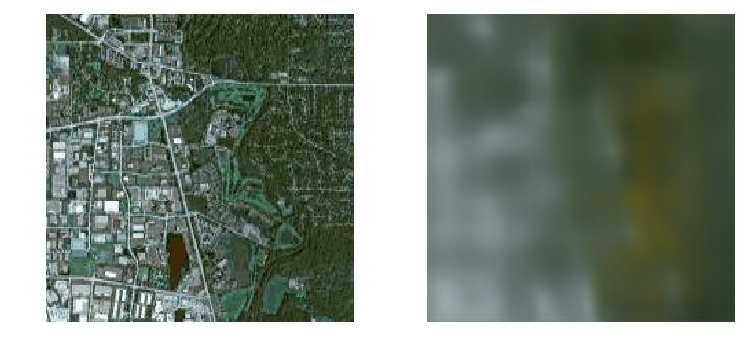

In [78]:
plot_image = 109
test_output_orig = inv_normalize(return_images[plot_image])

fig, ax = plt.subplots(1, 2, figsize=(9,4))
ax[0].imshow(testset[plot_image][1].permute(1, 2, 0))
ax[0].axis('off')
ax[1].imshow(test_output_orig.cpu().detach().permute(1, 2, 0))
ax[1].axis('off')
plt.show()